In [4]:
# Install catalax
# !pip install catalax

In [5]:
import catalax as ctx
import catalax.neural as ctn

In [6]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

model

,name,symbol
0,s1,s1


,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None



Model(
    name='Simple menten model',
    odes=DottedDict({'s1': ODE(species=Species(name='s1', symbol=s1), equation=-s1*v_max/(K_m + s1), observable=True, parameters=DottedDict({'K_m': Parameter(name='K_m', symbol=K_m, value=100.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, prior=None), 'v_max': Parameter(name='v_max', symbol=v_max, value=7.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, prior=None)}))}),
    species=,
    parameters=,
    term=None
)

/Users/janrange/GitHub/Catalax/catalax/dataset/dataset.py:542: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=4, h_pad=4)


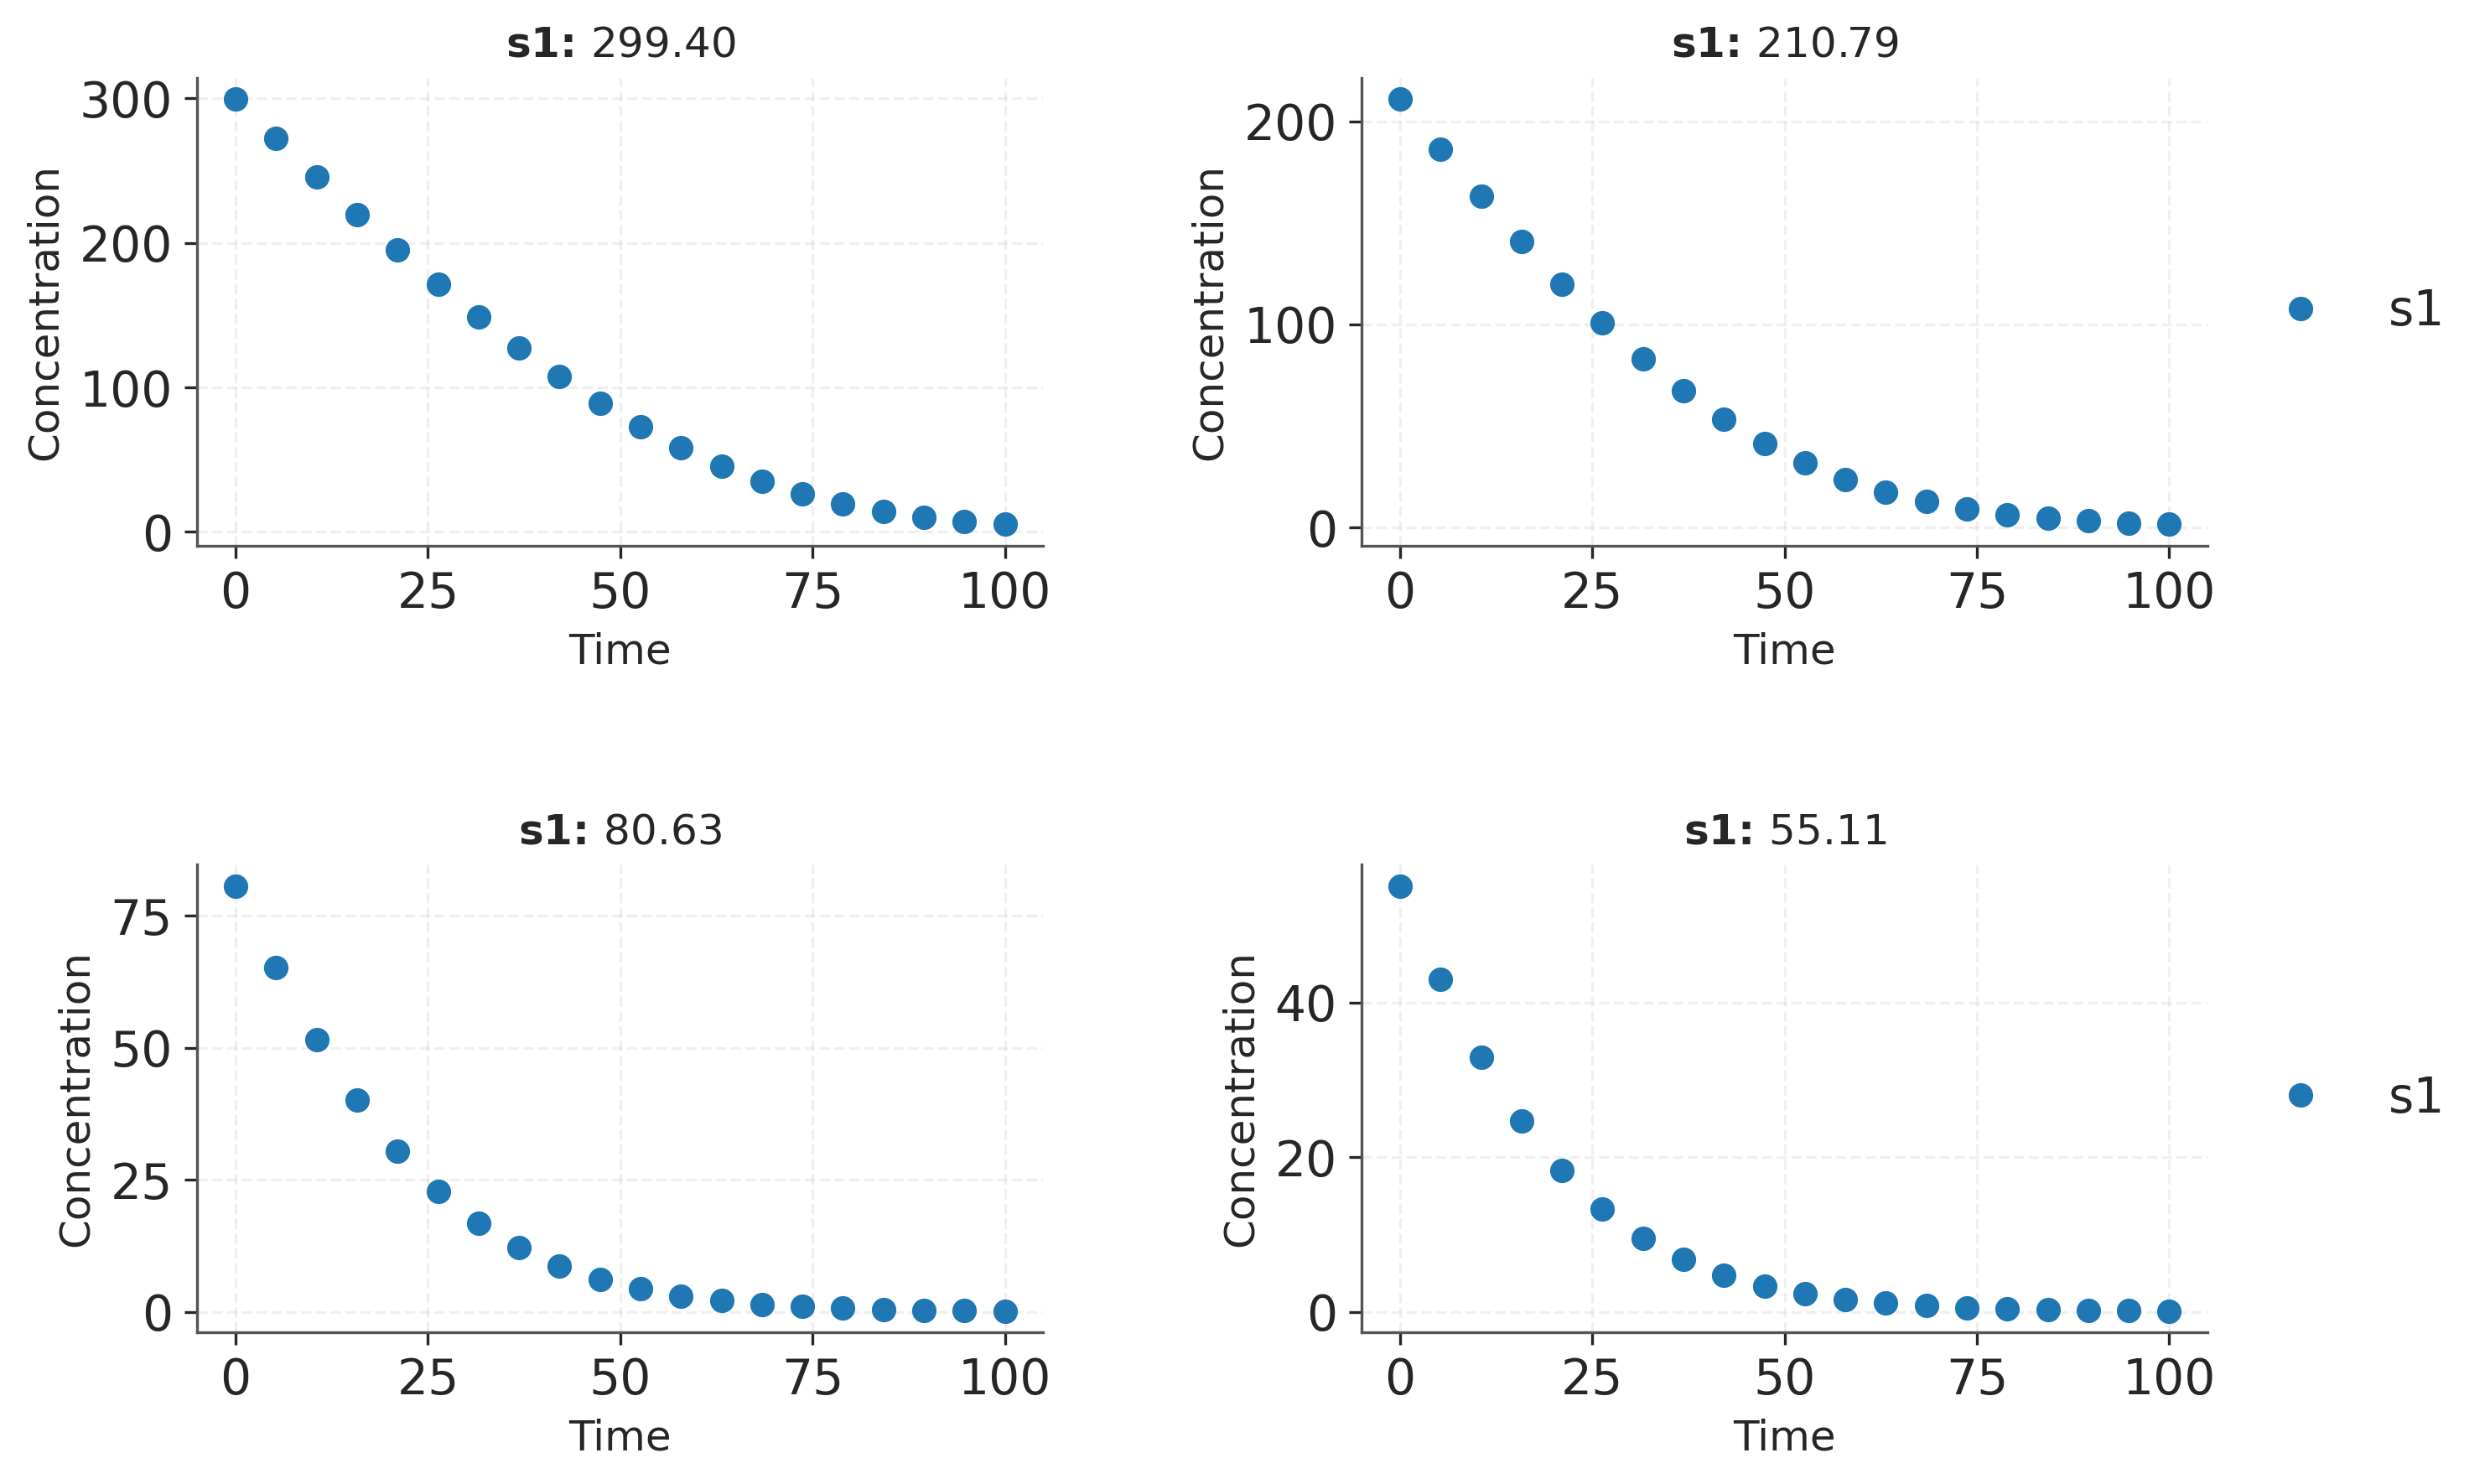

In [12]:
# Load the dataset
dataset = ctx.Dataset.from_croissant("./dataset/dataset.zip")

# Augment the dataset
dataset = dataset.augment(n_augmentations=10, sigma=0.1)

f = dataset.plot(measurement_ids=[m.id for m in dataset.measurements[:4]])

In [13]:
# Create a neural ODE model
rbf = ctn.RBFLayer(0.6)
neural_ode = ctn.NeuralODE.from_model(model, width_size=16, depth=1, activation=rbf)

# Set up a training strategy (You can interchange the loss function too!)
strategy = ctn.Strategy()
strategy.add_step(lr=1e-3, length=0.1, steps=1000, batch_size=20, alpha=0.1)
strategy.add_step(lr=1e-3, steps=3000, batch_size=20, alpha=0.01)
strategy.add_step(lr=1e-4, steps=5000, batch_size=20, alpha=0.01)

# Train neural ODE
trained = ctn.train_neural_ode(
    model=neural_ode,
    dataset=dataset,
    strategy=strategy,
    print_every=10,
    weight_scale=1e-3,
    save_milestones=False,  # Set to True to save model checkpoints
    # log="progress.log", # Uncomment this line to log progress
)



🚀 Training NeuralODE...

🔸 Step #1
├── lr: 0.001
├── batch size: 20
├── length: 10.0%
├── l2 reg: 0.1
├── train: mlp
│


╰── loss: 0.5963 mae: 0.6626: : 1010it [00:07, 132.79it/s]                        




🔸 Step #2
├── lr: 0.001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.5574 mae: 0.7999: : 3010it [00:29, 102.47it/s]                         




🔸 Step #3
├── lr: 0.0001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.0995 mae: 0.3159: : 5010it [00:48, 104.17it/s]                        

In [15]:
# Save model
trained.save_to_eqx("./trained/", "menten_trained")